In [9]:
# A little thing to suppress warnings I know will come up...comment off for testing
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [17]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.interpolate import interp1d

nuc_to_astro = 0.8629*1e-6

def read_eos(pathname):
    """
    Read in equation of state information from tabulated format.
    This is written assuming the following order:
    0: number density [fm-3]
    1: pressure [Mev fm-3]
    2: energy density [Mev fm-3]
    Conversion factor: 1 [Mev fm-3] = 0.89629x10^-6 [Msol c2 km-3]
    """
    
    src = np.loadtxt(pathname, comments='#')
    P, e = src[:,1], src[:,2]
    p, e = P*nuc_to_astro, e*nuc_to_astro
    return (p,e)
    
def make_derivs_func(pathname):
    pdata, edata = read_eos(pathname)
    eos = interp1d(pdata,edata)
    
    def derivs(p,y):
        """
        e: e_of_P function
        """
        e = eos(p)
        x,m = y
        dxdp = -2*x*(np.sqrt(x)-(2*m))/((e+p)*(m+(4*np.pi*p*x**(3/2))))
        dmdp = -((4*np.pi*e*x**(3/2))*(np.sqrt(x)-2*m))/((e+p)*(m+(4*np.pi*p*x**(3/2))))
        return dxdp,dmdp
    
    return derivs

def solve_tov(p_init,pathname,method):
    """
    Inputs:
    - p,e: functions for EOS
    - p_init: Value of central pressure (start with 0.8*nuc_to_astro)
    - Method: integration method; choices are: 
      RK45,RK23,DOP853,Radau,BDF,LSODA
    Initial conditions: P(0) = P[index]
    Note: I took max_step out for now because it seems to work fine without it, 
    and including it slows down the calculation considerably
    """
    
    derivs = make_derivs_func(pathname)

    p_range = [p_init,1e-16]
    y0 = [1e-14,1e-14]
    sol = solve_ivp(derivs, p_range, y0, dense_output=True, 
                    rtol=1e-6, atol=1e-7, method=method)
    return sol

In [29]:
import traceback
rs = 2.95 # Schwarzschild radius in km for 1 M_sol star
print('\n')

path = 'Nucleonic_EOS.dat'
radmass = {'LSODA':[],'RK45':[]}
P_vals = np.geomspace(2,2000,50)
for P in P_vals:
    try:
        init_p = P*nuc_to_astro
        for method in radmass.keys():
            sol = solve_tov(init_p, path, method)
            radmass[method].append([np.sqrt(sol.y[0][-1]), sol.y[1][-1]])
    except:
        traceback.print_exc()
for method in radmass.keys():
    radmass[method] = np.array(radmass[method])
    print('Maximum mass using',method, ': %1.2f M_sun'%max(radmass[method][:,1]))
print('\n')



Maximum mass using LSODA : 3.75 M_sun
Maximum mass using RK45 : 3.75 M_sun




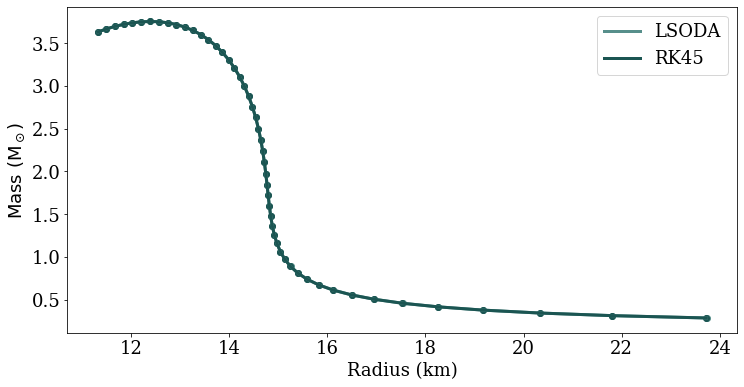

In [28]:
colors = {'RK45':'#1b5552','LSODA':'#578f8b'}
plt.rcParams['font.family'],plt.rcParams['font.size'] = 'serif',18

mfactor, rfactor = 1.8,1.2

plt.figure(figsize=(12,6))
for method in radmass.keys():
    radius,mass = radmass[method][:,0],radmass[method][:,1]
    plt.plot(radius, mass, linewidth=3,label=method, color=colors[method])
    plt.scatter(radius, mass, color=colors[method])
plt.legend(loc='best')
_ = plt.xlabel('Radius (km)'), plt.ylabel(r'$\rm{Mass\ (M_\odot)}$')
#plt.savefig('LSODA_scatter.png', facecolor='w', bbox_inches='tight')